## Generating Events

In [1]:
import numpy as np

# Event types
floatevent = 0

# Generate event of random size within range
# Return array representing event
def generate_event(event_size, rand_multiplier = 10):
    return np.array(rand_multiplier*np.random.rand(1, event_size), dtype='int16')

# Return array of n events of form (time, data)
# with times separated within dt range
# with data within size range
def generate_n_events(n, dt_min, dt_max, event_size):
    t = 0
    events = []
    for i in range(n):
        events.append((t, generate_event(event_size)))
        dt = dt_min + (np.random.random() * (dt_max - dt_min))
        t += dt
    return events

generate_n_events(3, 0.5, 0.8, 5000)

[(0, array([[4, 3, 3, ..., 1, 8, 8]], dtype=int16)),
 (0.50729023372637, array([[4, 4, 2, ..., 6, 5, 9]], dtype=int16)),
 (1.101198357713693, array([[5, 2, 1, ..., 4, 7, 1]], dtype=int16))]

### Simulation

In [2]:
import time
import h5py

# Run a simulation with the given parameters
# n_events is number of events to group together to write to hdf5
def run_sim(n, group_size, dt_min, dt_max, event_size, file="out.h5"):
    hf = h5py.File('data.h5', 'w')
    
    events = generate_n_events(n, dt_min, dt_max, event_size)
    
    group = []
    written = 0
    count = 0
    start = time.time()
    # Write the events to hdf5
    while count < n:
        now = time.time() - start

        # Next event has not fired yet
        if events[count][0] > now:
            # time.sleep is actually too sloww
            # time.sleep(0.001)
            continue
        
        # If the event has fired
        if group_size == 1:
            hf.create_dataset("event%d"%(count), data=events[count][1][0])
            written += 1
            count += 1
        elif group_size > 1:
            group.append(events[count][1][0])
            if len(group) >= group_size or count == n-1:
                hf.create_dataset("events%d"%(written), data=group)
                written += 1
                group = []
            count += 1

    hf.close()
    
    return time.time() - start

## Confirming data from hdf5

In [3]:
n_events = 5
print(run_sim(n_events, 2, 1, 2, 100), "s")

5.486940860748291 s


In [4]:
f = h5py.File('data.h5', 'r')
keys = list(f.keys())
print("Keys:", keys, "\n")

count = 0
for key in keys:
    data = np.array(f[key])
    print("Group %d size:"%count, data.shape)
    count += 1

print("\nFirst group:", list(f[keys[0]]))

f.close()

Keys: ['events0', 'events1', 'events2'] 

Group 0 size: (2, 100)
Group 1 size: (2, 100)
Group 2 size: (1, 100)

First group: [array([0, 3, 1, 6, 4, 2, 7, 9, 6, 1, 5, 4, 8, 9, 5, 2, 5, 7, 6, 9, 8, 1,
       1, 3, 9, 8, 4, 3, 2, 7, 7, 3, 4, 4, 5, 8, 0, 8, 3, 0, 8, 8, 4, 8,
       3, 2, 3, 7, 0, 8, 6, 4, 2, 6, 1, 6, 3, 5, 6, 9, 8, 1, 7, 4, 2, 9,
       1, 6, 6, 3, 9, 3, 9, 0, 8, 7, 2, 2, 9, 2, 8, 0, 1, 8, 4, 6, 8, 8,
       3, 4, 6, 0, 4, 1, 0, 8, 7, 3, 7, 4], dtype=int16), array([7, 4, 4, 4, 3, 5, 6, 9, 0, 3, 7, 2, 8, 5, 8, 4, 7, 1, 4, 8, 7, 8,
       2, 1, 6, 9, 4, 6, 9, 5, 3, 0, 0, 4, 2, 0, 4, 0, 8, 9, 9, 8, 7, 4,
       1, 1, 7, 6, 4, 8, 8, 7, 2, 8, 4, 7, 3, 1, 0, 1, 4, 6, 0, 8, 6, 0,
       3, 6, 2, 3, 8, 9, 2, 6, 7, 6, 1, 5, 1, 2, 5, 1, 2, 9, 3, 7, 4, 2,
       4, 8, 9, 9, 8, 6, 3, 7, 8, 3, 4, 2], dtype=int16)]


## Testing

### Group Size vs BW for dt = 1/4000 seconds and 1/10000 seconds

In [5]:
from pylab import plot, xlabel, ylabel, title, show

def plot_results(group_sizes, run_times, event_size, n):
    bandwidths = (event_size * 16 * n) / np.array(run_times)
    bandwidths = bandwidths / 8E6 # b/s to MB/s
    
    plot(group_sizes, bandwidths, 'r.')
    title("Group Size vs Bandwidth")
    xlabel("Group size (events)")
    ylabel("Bandwidth (MB/s)")
    show()

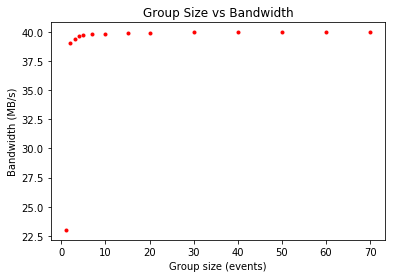

In [6]:
# Intitially test with constant dt
dt_min = 1/4000.0
dt_max = 1/4000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 16000 events (~4 seconds)
n = 16000

for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size))

plot_results(group_sizes, run_times, event_size, n)

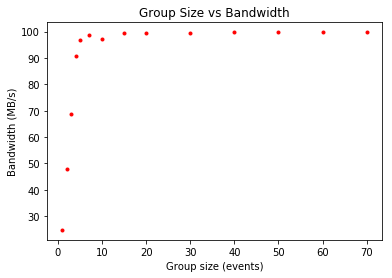

In [7]:
# Intitially test with constant dt
dt_min = 1/10000.0
dt_max = 1/10000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 40000 events (~4 seconds)
n = 40000
for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size))

plot_results(group_sizes, run_times, event_size, n)

### Trying 30 seconds per simulation

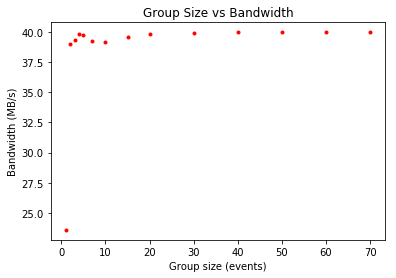

In [8]:
# Intitially test with constant dt
dt_min = 1/4000.0
dt_max = 1/4000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 120000 events (~30 seconds)
n = 120000
for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size))

plot_results(group_sizes, run_times, event_size, n)

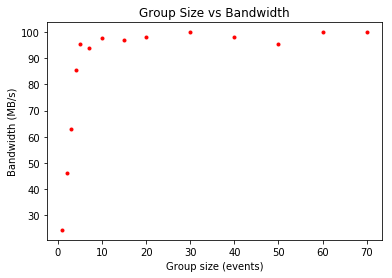

In [9]:
# Intitially test with constant dt
dt_min = 1/10000.0
dt_max = 1/10000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 300000 events (~30 seconds)
n = 300000
for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size))

plot_results(group_sizes, run_times, event_size, n)

### Does decreasing event size improve? 
Or is it the frequency of events? Trying different event sizes with group size=1 while holding freq constant:

In [13]:
def plot_results_es(event_sizes, run_times, n):
    bandwidths = (n) / np.array(run_times)
    
    plot(event_sizes, bandwidths, 'b.')
    title("Events per Second vs Event Size")
    xlabel("Event size (Num 16 Bit Words)")
    ylabel("Events per Second")
    show()

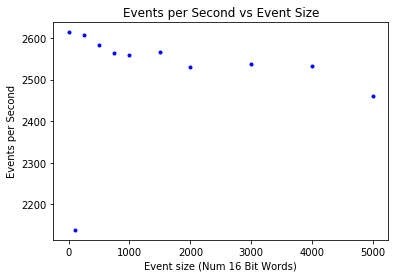

In [14]:
# Intitially test with constant dt
dt_min = 1/10000.0
dt_max = 1/10000.0
group_size = 1

event_sizes = [1, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]

# Randomize order of group size
np.random.shuffle(event_sizes)

run_times = []

# 150000 events (~15 seconds)
n = 150000
for es in event_sizes:
    run_times.append(run_sim(n, group_size, dt_min, dt_max, es))

plot_results_es(event_sizes, run_times, n)